Copyright CNES

# Plot a lake timeseries from multiple Lake/River Single Pass products

In this notebook, we show how to read the SWOT-HR River or Lake Single Pass vector products with geopandas and dask dataframes and how to represent a variable in time.
The example is based on Lake Single Pass Prior products, but it would be the same methodology for all vector products relying on a feature ID

## Libraries

In [1]:
import glob

import numpy as np
import geopandas as gpd
from tqdm import tqdm

from dask import dataframe as dd
import dask_geopandas as dgpd
from datetime import datetime as dt


## Select all Lake Single-Pass products within our directory

### Filter by filename pattern

In [2]:
filename_list = glob.glob("../docs/data/swot/SWOT_L2_HR_LakeSP_Prior/*PIC0_01/*PIC0_01.zip")
print(len(filename_list))
# one can use zip files, but note it is slower

49


# Load all data
now we want to load all data from all file in lazy mode, otherwise it will not fit into RAM.  
For this, we will iteratively read all files with geopandas, and store data in a dask dataframe.  
The drawback of this approach is that you cannot keep the geometries. However, if you are fine with that, it is very efficient.  
One could hack that by changing geometries into strings and, once the data has been filter, converting back to geometries and a geopandas.Dataframe

In [3]:
def load_layers(files):
    
    ddf = None
    for file in tqdm(files):

        gdf = gpd.read_file(
            file,
            engine='pyogrio',
            use_arrow=True,
            )   
        
        ddf_tmp = dgpd.from_geopandas(gdf, chunksize=10000)
        
        if ddf is None:
            ddf = ddf_tmp
        else:
            ddf = dd.concat([ddf, ddf_tmp ], ignore_order=True)

    del ddf_tmp, gdf

    return ddf

In [4]:
ddf = load_layers(filename_list)
ddf

100%|██████████| 49/49 [00:38<00:00,  1.27it/s]


,lake_id,reach_id,obs_id,overlap,n_overlap,time,time_tai,time_str,wse,wse_u,wse_r_u,wse_std,area_total,area_tot_u,area_detct,area_det_u,layovr_val,xtrk_dist,ds1_l,ds1_l_u,ds1_q,ds1_q_u,ds2_l,ds2_l_u,ds2_q,ds2_q_u,quality_f,dark_frac,ice_clim_f,ice_dyn_f,partial_f,xovr_cal_q,geoid_hght,solid_tide,load_tidef,load_tideg,pole_tide,dry_trop_c,wet_trop_c,iono_c,xovr_cal_c,lake_name,p_res_id,p_lon,p_lat,p_ref_wse,p_ref_area,p_date_t0,p_ds_t0,p_storage,geometry
npartitions=165,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,string,string,string,string,string,float64,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,int32,float64,float64,float64,float64,string,float64,float64,geometry
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [32]:
ddf.lake_id.compute()

0        2210007102
1        2210007142
2        2210007192
3        2210007522
4        2230000012
            ...    
33951    2230021903
33952    2830061673
33953    2940020732
33954    2220006512
33955    2220008312
Name: lake_id, Length: 1456270, dtype: string

## Focus on our lake of interest
If you do not know the ID of your lake of interest, you can get it the SWOT Prior Lake Database.
This database can be viewed and/or downloaded from the hydroweb.next platform.
You will find the SWOT Prior Lake Database (PLD) among the 'Results' from [hydroweb.next](https://hydroweb.next.theia-land.fr?pid=SWOT_PRIOR_LAKE_DATABASE). If you do not want to download it, click on "+Project" icon to add it to your project and click on the "EYE" icon to display this vector layer into the current map selection. Note that you may have to place this product on top of the products in your "Project" panel or unselect the "EYE" icon of the other products, in order to view the PLD layer on the map. On the map click inside the water body of interest (here the "river-lake" we are studying) and you will see more details about it in the 'Select' panel. 

In [59]:
MY_LAKE_ID = '2940022112'
MY_LAKE_ID = '2940021962'

df_vs = ddf[ddf['lake_id'] == MY_LAKE_ID].compute()

# Interpreting the dates as dates with the datetime library
df_vs['date'] = df_vs['time_str'].apply(
    lambda t: np.nan if t =='no_data' else dt.fromisoformat(t.strip('Z'))
    )

# sorting values based on dated
df_vs.sort_values('date', inplace=True)

# interpreting NaNs (shapefiles have no system to identify fillvalues)
df_vs = df_vs[df_vs['wse']>-1e10] 

df_vs

,lake_id,reach_id,obs_id,overlap,n_overlap,time,time_tai,time_str,wse,wse_u,...,p_res_id,p_lon,p_lat,p_ref_wse,p_ref_area,p_date_t0,p_ds_t0,p_storage,geometry,date
24386,2940021962,no_data,294094R099897,0,1,7.617207e+08,7.617207e+08,2024-02-20T05:05:48Z,117.685,0.791,...,-99999999,44.416265,34.690836,-1.000000e+12,119.034902,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((44.56503 34.55532, 44.56499 34...",2024-02-20 05:05:48
19967,2940021962,no_data,294094L099732;294094L099863;294094L099955;2940...,42;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0...,58,7.626653e+08,7.626653e+08,2024-03-02T03:28:37Z,113.316,0.030,...,-99999999,44.416265,34.690836,-1.000000e+12,119.034902,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((44.34098 34.84831, 44.34081 34...",2024-03-02 03:28:37
27266,2940021962,no_data,294094L099739;294094L099973;294094L099832;2940...,42;1;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0...,60,7.644680e+08,7.644680e+08,2024-03-23T00:13:40Z,114.799,0.053,...,-99999999,44.416265,34.690836,-1.000000e+12,119.034902,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((44.26363 34.82676, 44.26342 34...",2024-03-23 00:13:40
11426,2940021962,no_data,294094L099894;294094L099975;294094L099435;2940...,42;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0...,57,7.680734e+08,7.680734e+08,2024-05-03T17:43:47Z,119.463,0.120,...,-99999999,44.416265,34.690836,-1.000000e+12,119.034902,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((44.27089 34.81043, 44.27067 34...",2024-05-03 17:43:47
8346,2940021962,no_data,294094L099811;294094L099884;294094L099963;2940...,42;1;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0...,44,7.698761e+08,7.698761e+08,2024-05-24T14:28:53Z,113.857,0.021,...,-99999999,44.416265,34.690836,-1.000000e+12,119.034902,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((44.33459 34.84880, 44.33441 34...",2024-05-24 14:28:53


Text(0.5, 1.0, 'Water Level for Lake ID 2940021962')

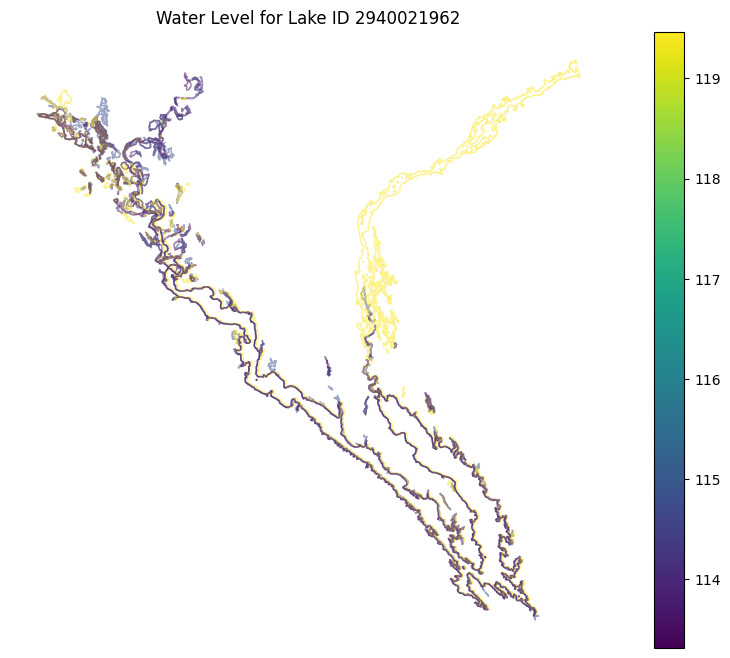

In [60]:
ax = df_vs.plot(
    column='wse',
    figsize=(12,8),
    cmap='viridis',
    alpha=.5,
    legend=True,
    facecolor='None',
)
ax.set_axis_off()
ax.set_title(f'Water Level (m) for Lake ID {MY_LAKE_ID}')